<a href="https://colab.research.google.com/github/ut-stack/Data_Collection/blob/master/cric_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

Enter player name: Rohit Sharma

Player Information:
Name: Rohit Sharma
Country: India
Test Matches: 61
Test Runs: 4180
Test Average: 44.0
ODI Matches: 265
ODI Runs: 10866
ODI Average: 49.17
T20 Matches: 159
T20 Runs: 4231
T20 Average: 31.34
Test Wickets: 2
Test Economy: 3.51
ODI Wickets: 9
ODI Economy: 5.24
T20 Wickets: 1
T20 Economy: 9.97


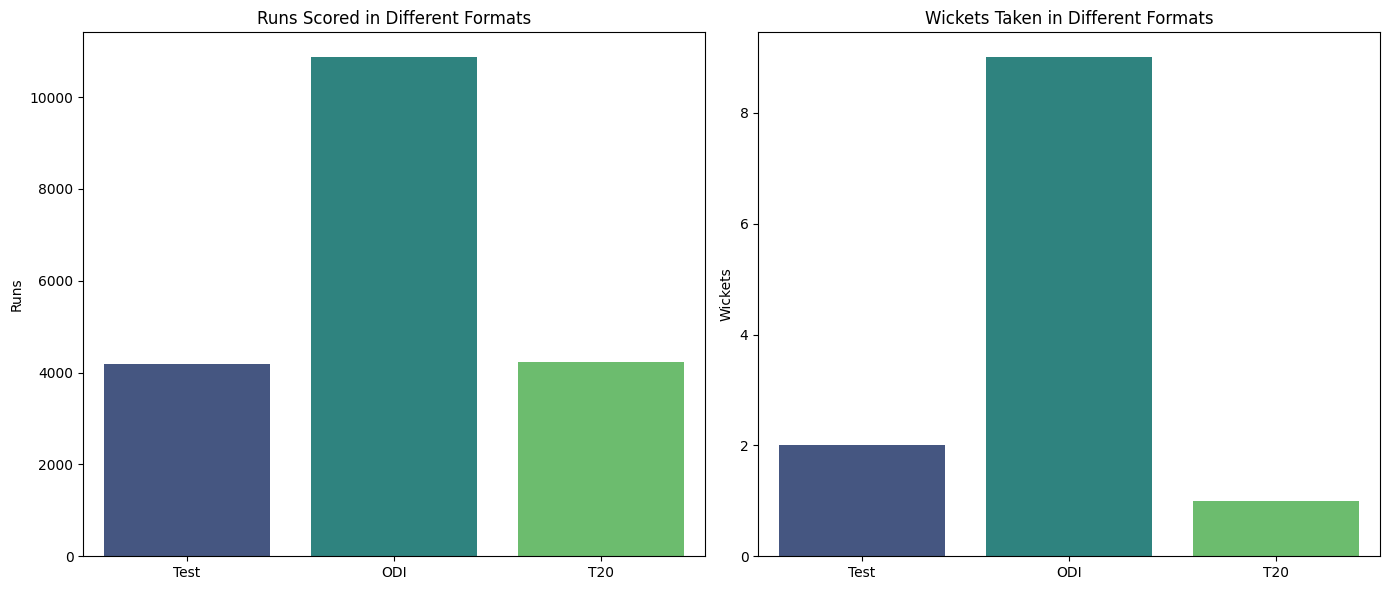

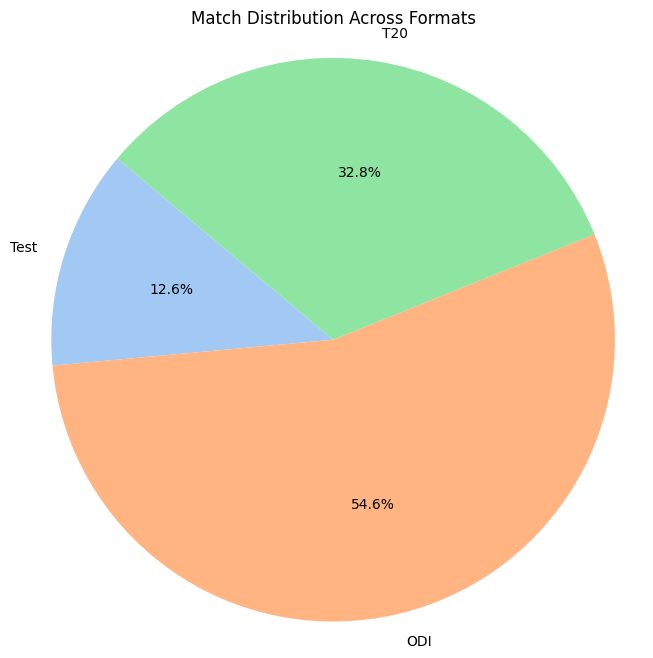

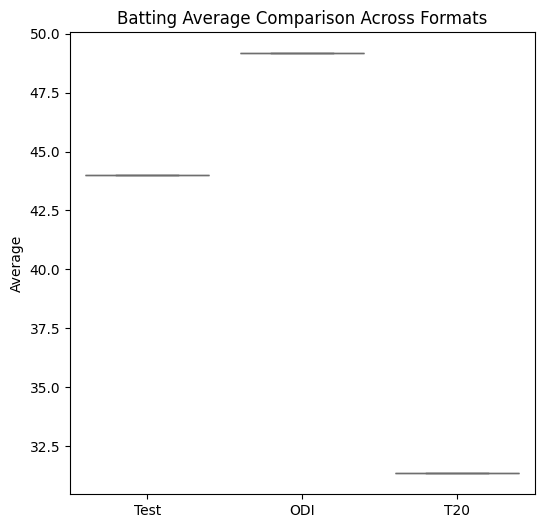

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import warnings

# Warning Management
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_player_statistics(player_name):
    """
    Fetches player statistics from Cricbuzz based on the player's name.
    Entering The name of the player to fetch statistics for.
    """
    # Google search URL to find the player's Cricbuzz profile
    search_url = f"https://www.google.com/search?q={player_name}%20cricbuzz"
    search_response = requests.get(search_url).text
    search_soup = BeautifulSoup(search_response, "lxml")

    # Extracting the Cricbuzz link from the search results
    try:
        search_result = search_soup.find("div", class_="kCrYT")
        link = search_result.find("a", href=re.compile(r"[/]([a-z]|[A-Z])\w+")).attrs["href"]
        cricbuzz_url = link[7:]  # Clean up the link to get the actual URL
    except Exception as e:
        print(f"Error: {e}. Could not find Cricbuzz page. Check player name spelling.")
        return None

    # Fetch the player's profile page from Cricbuzz
    response = requests.get(cricbuzz_url).text
    soup = BeautifulSoup(response, "lxml")

    # Extract the player profile information
    profile_section = soup.find("div", id="playerProfile")
    if not profile_section:
        print("Error: Could not fetch player profile details.")
        return None

    player_info = {}

    # Extracting basic player information
    try:
        player_info['Name'] = profile_section.find("h1", class_="cb-font-40").text.strip()
        player_info['Country'] = profile_section.find("h3", class_="cb-font-18 text-gray").text.strip()
    except Exception as e:
        print(f"Error: {e}. Could not find basic player information.")

    # Extract batting and bowling statistics
    summary_section = soup.find_all("div", class_="cb-plyr-tbl")
    if len(summary_section) < 2:
        print("Error: Could not find player statistics.")
        return None

    batting_stats = summary_section[0].find_all("td", class_="text-right")
    bowling_stats = summary_section[1].find_all("td", class_="text-right")

    # Store batting stats for different formats
    player_info['Test Matches'] = batting_stats[0].text.strip()
    player_info['Test Runs'] = batting_stats[3].text.strip()
    player_info['Test Average'] = batting_stats[5].text.strip()
    player_info['ODI Matches'] = batting_stats[13].text.strip()
    player_info['ODI Runs'] = batting_stats[16].text.strip()
    player_info['ODI Average'] = batting_stats[18].text.strip()
    player_info['T20 Matches'] = batting_stats[26].text.strip()
    player_info['T20 Runs'] = batting_stats[29].text.strip()
    player_info['T20 Average'] = batting_stats[31].text.strip()

    # Store bowling stats for different formats
    player_info['Test Wickets'] = bowling_stats[4].text.strip()
    player_info['Test Economy'] = bowling_stats[7].text.strip()
    player_info['ODI Wickets'] = bowling_stats[16].text.strip()
    player_info['ODI Economy'] = bowling_stats[19].text.strip()
    player_info['T20 Wickets'] = bowling_stats[28].text.strip()
    player_info['T20 Economy'] = bowling_stats[31].text.strip()

    # Convert the dictionary of player info to a DataFrame
    df = pd.DataFrame([player_info])

    # Convert relevant columns to numeric types, handling any errors
    numeric_columns = ['Test Matches', 'Test Runs', 'Test Average', 'ODI Matches', 'ODI Runs', 'ODI Average',
                       'T20 Matches', 'T20 Runs', 'T20 Average', 'Test Wickets', 'Test Economy', 'ODI Wickets',
                       'ODI Economy', 'T20 Wickets', 'T20 Economy']

    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')  # Coerce errors to NaN

    # Fill any NaN values with 'N/A'
    df.fillna("N/A", inplace=True)

    return df

def visualize_player_statistics(player_df):
    """Visualizes player statistics using bar charts, pie charts, and box plots."""

    # select format
    formats = ['Test', 'ODI', 'T20']

    # data for visualization
    runs = [player_df[f'{format} Runs'].values[0] for format in formats]
    wickets = [player_df[f'{format} Wickets'].values[0] for format in formats]

    # bar plots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart for Runs scored in different formats
    sns.barplot(x=formats, y=runs, ax=ax[0], palette="viridis")
    ax[0].set_title('Runs Scored in Different Formats')
    ax[0].set_ylabel('Runs')

    # Bar chart for Wickets taken in different formats
    sns.barplot(x=formats, y=wickets, ax=ax[1], palette="viridis")
    ax[1].set_title('Wickets Taken in Different Formats')
    ax[1].set_ylabel('Wickets')

    plt.tight_layout()  # layout adjustment
    plt.show()

    # Pie chart
    matches = [player_df[f'{format} Matches'].values[0] for format in formats]
    plt.figure(figsize=(8, 8))
    plt.pie(matches, labels=formats, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title('Match Distribution Across Formats')
    plt.axis('equal')
    plt.show()

    # Box plot
    averages = [player_df[f'{format} Average'].values[0] for format in formats]
    plt.figure(figsize=(6, 6))
    sns.boxplot(x=formats, y=averages, palette="coolwarm")
    plt.title('Batting Average Comparison Across Formats')
    plt.ylabel('Average')
    plt.show()

# Prompt user for player name
player_name = input("Enter player name: ")

# Fetch player statistics
player_df = get_player_statistics(player_name)

# Display player stats if available
if player_df is not None:
    print("\nPlayer Information:")
    # Print player info vertically
    for column in player_df.columns:
        print(f"{column}: {player_df[column].values[0]}")

    # Visualize player statistics
    visualize_player_statistics(player_df)
else:
    print("Failed to retrieve player statistics.")
